In [2]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels 
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns 
import utils 

- Autocorrelation:
    - test visuelle 
    - durbin watson 
    - ljung box
- Normalitée:
    - test visuelle 
    - jarque bera 
    - shapiro
    - kolmogorov smirnov
- heteroscedaticy:
    - Test visuelle 
    - ARCH 
    - white 
    - breutch pegan 
- multicol 
    - vif
    - eigenvalue
    

In [3]:
df = pd.read_csv('data/final.csv')
df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,bmi,charges,smoker_no,smoker_yes,categorie_age_Adulte,categorie_age_Jeune,categorie_age_Sénior,bmi_log,charges_log,charges_log2,bmi_log2,smoking_status
0,0,0,0,27.90,16884.9240,0,1,0,1,0,3.328627,9.734176,2.275643,1.202560,1
1,1,1,1,33.77,1725.5523,1,0,0,1,0,3.519573,7.453302,2.008657,1.258340,0
2,2,2,2,33.00,4449.4620,1,0,0,1,0,3.496508,8.400538,2.128296,1.251765,0
3,3,3,3,28.88,3866.8552,1,0,0,1,0,3.363149,8.260197,2.111448,1.212878,0
4,4,4,4,25.74,3756.6216,1,0,0,1,0,3.248046,8.231275,2.107941,1.178054,0


In [4]:
t , _ = scipy.stats.boxcox(df['charges'].values)
b , l = scipy.stats.boxcox(df['bmi'].values)
df['charges_cox'] = t
df['bmi_cox'] = b

In [5]:

#data[['smoking_status', 'charges_cox_cluster_mean']]
cluster_means = df.groupby('smoking_status')[['charges_cox', 'bmi']].mean().reset_index()

# Merge the mean values of 'charges' back into the original DataFrame
df_with_means = df.merge(cluster_means, on='smoking_status', suffixes=('', '_cluster_mean'))

data = df_with_means
df = df_with_means
data.columns


Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'bmi', 'charges',
       'smoker_no', 'smoker_yes', 'categorie_age_Adulte',
       'categorie_age_Jeune', 'categorie_age_Sénior', 'bmi_log', 'charges_log',
       'charges_log2', 'bmi_log2', 'smoking_status', 'charges_cox', 'bmi_cox',
       'charges_cox_cluster_mean', 'bmi_cluster_mean'],
      dtype='object')

In [6]:
#modeling charges_cox_cluster_mean = f(bmi_cox, smoker_yes ....)
model = sm.formula.ols(formula='charges_cox_cluster_mean ~ bmi_cox+smoker_yes+categorie_age_Jeune+categorie_age_Adulte-1 ',
                       data=data)
fit = model.fit(cov_type='HC0')
fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     charges_cox_cluster_mean   R-squared (uncentered):                   0.990
Model:                                  OLS   Adj. R-squared (uncentered):              0.990
Method:                       Least Squares   F-statistic:                          3.434e+04
Date:                      Tue, 26 Nov 2024   Prob (F-statistic):                        0.00
Time:                              11:27:38   Log-Likelihood:                         -1585.9
No. Observations:                      1256   AIC:                                      3180.
Df Residuals:                          1252   BIC:                                      3200.
Df Model:                                 4                                                  
Covariance Type:                        HC0                                                  
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
bmi_cox                  1.0038      0.006    179.946      0.000       0.993       1.015
smoker_yes               1.5224      0.051     29.977      0.000       1.423       1.622
categorie_age_Jeune      0.5041      0.057      8.820      0.000       0.392       0.616
categorie_age_Adulte     0.4402      0.058      7.533      0.000       0.326       0.555
==============================================================================
Omnibus:                        0.009   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.996   Jarque-Bera (JB):                0.002
Skew:                          -0.003   Prob(JB):                        0.999
Kurtosis:                       2.997   Cond. No.                         23.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC0)
"""

In [7]:
#autocorrelation
resid = fit.resid
utils._durbin(resid)

Durbin-Watson Statistic: 2.0686627794424206
There’s no significant autocorrelation in your residuals.


In [8]:
utils._ljbox(resid, lags=12)

Ljung-Box Test Statistic: 10.908376581867866, p-value: 0.5367867611854709
No significant autocorrelation detected in the residuals (do not reject null hypothesis).


<Axes: >

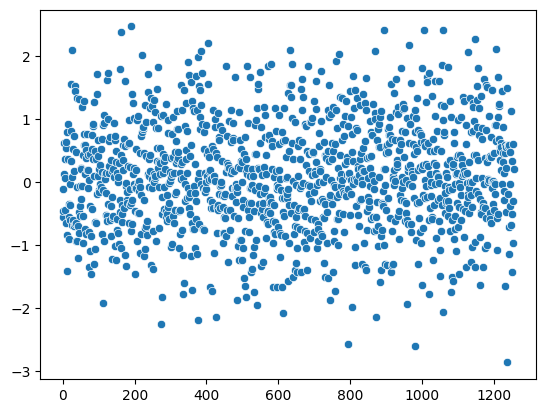

In [9]:
sns.scatterplot(resid)

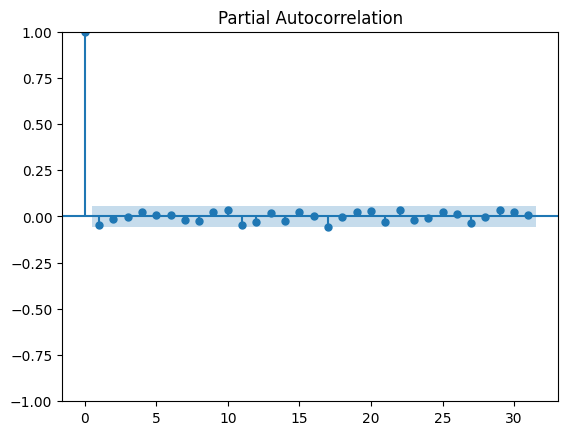

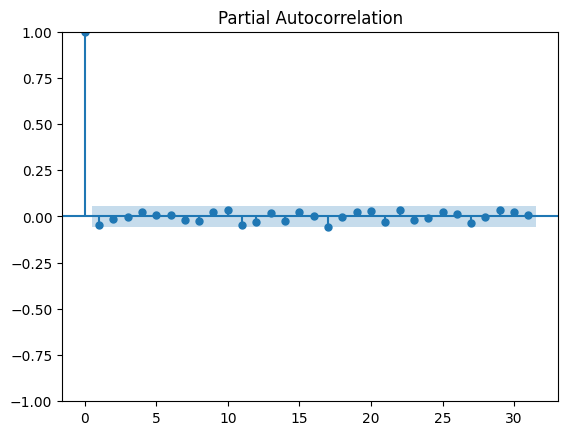

In [10]:
statsmodels.graphics.tsaplots.plot_pacf(resid)

In [11]:
#heteroscedaticity
exog = fit.model.exog 
utils._white(resid, exog )

White Test Statistic (LM): 1232.1290968817568, p-value: 1.6892118394254184e-258
White Test Statistic (F): 6426.236653130385, p-value: 0.0


'Decision: Reject the null hypothesis. Evidence of heteroskedasticity.'

In [12]:
utils._breuschpg(fit.resid, fit.model.exog)

Breusch-Pagan Test Statistic: 44.33373658963941, p-value: 5.469136316525728e-09
Decision: Reject the null hypothesis. There is evidence of heteroskedasticity.


In [13]:
utils._jarqueb(fit.resid)

Jarque-Bera Statistic: 0.0023993854506039057, p-value: 0.998801026618323
Residuals are normally distributed (do not reject null hypothesis).


<Axes: ylabel='Count'>

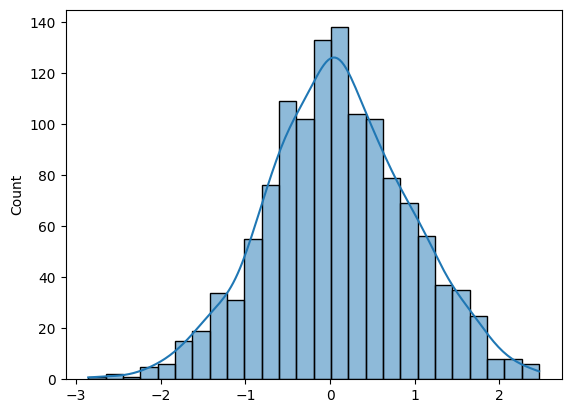

In [14]:
sns.histplot(fit.resid, kde=True)

In [15]:
#multicol
utils.detect_multicollinearity(pd.DataFrame(exog))


'No significant multicollinearity detected. Condition number: 3.36. (Threshold: 30)'

In [16]:
exog = data[['bmi_cox','smoker_yes','categorie_age_Jeune','categorie_age_Adulte']]

y_pred = fit.predict(exog)

y = data['charges_cox_cluster_mean'].values

In [17]:
utils.rmse(y, y_pred)

0.8553207028251867

In [18]:
utils.mae(y, y_pred)

0.6742398212785299

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare data (X: features, y: target)
X = data[['bmi_cox', 'smoker_yes', 'categorie_age_Jeune', 'categorie_age_Adulte']]
y = data['charges_cox_cluster_mean']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit Gradient Boosting model
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test)

# Calculate R-squared, RMSE, MAE for Gradient Boosting
r2_gb = gb_model.score(X_test, y_test)  # R-squared for the model

# RMSE and MAE
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print(f"Gradient Boosting - R-squared: {r2_gb}, RMSE: {rmse_gb}, MAE: {mae_gb}")


Gradient Boosting - R-squared: 0.999999999294341, RMSE: 1.645557639382291e-05, MAE: 1.31794361115973e-05


In [20]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Prepare data (X: features, y: target)
X = data[['bmi_cox', 'smoker_yes', 'categorie_age_Jeune', 'categorie_age_Adulte']]
y = data['charges_cox_cluster_mean']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit Gradient Boosting model
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test)

# Calculate R-squared, RMSE, MAE for Gradient Boosting
r2_gb = gb_model.score(X_test, y_test)  # R-squared for the model

# RMSE and MAE
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print(f"Gradient Boosting - R-squared: {r2_gb}, RMSE: {rmse_gb}, MAE: {mae_gb}")


Gradient Boosting - R-squared: 0.999999999294341, RMSE: 1.645557639382291e-05, MAE: 1.31794361115973e-05
